In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple, Dict
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Make sure exercises are in the path
sys.path.append(str(Path.cwd().parent))
from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)


device = t.device("cuda" if t.cuda.is_available() else "cpu")

sys.path.append('../Models_of_superposition/')
from superposition_lib import Config, get_angle, create_mask_from_group_members, create_diagonal_mask,Model, WtW

from sae_lib import AutoEncoder, AutoEncoderConfig
from sklearn.decomposition import PCA



In [6]:
SAE_config = AutoEncoderConfig(50,20,80,l1_coeff = 0.01)
SAE = AutoEncoder(SAE_config)

In [7]:
state_dict = t.load("data/sae_1/SAE_model.pth")
SAE.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
dicts_of_models = t.load("../Models_of_superposition/data/experiment_1/model.pth")
feature_probability = t.load("../Models_of_superposition/data/experiment_1/feature_probability.pth")
group_size = 5
inner_goup_distance = 0.1
p_transfer = 0.9
n_instances = len(feature_probability)
n_features = dicts_of_models["W"].shape[2]
n_hidden = dicts_of_models["W"].shape[1]
groupings =[[dict(members=list(range(i, i+group_size)), semantic_distance=inner_goup_distance, p_transfer = p_transfer) for i in range(0, n_features, group_size)] for _ in range(n_instances)]
cfg = Config(
    n_instances = n_instances,
    n_features = n_features,
    n_hidden = n_hidden,
)

model = Model(
    cfg = cfg,
    device = device,
    feature_probability = feature_probability,
    groupings = groupings,
)
model.load_state_dict(dicts_of_models)

<All keys matched successfully>

In [126]:
def get_active_features(SAE, model, comparison_factor = 1):
    batch = model.generate_batch(1000)
    h = model.encode(batch)
    l1_loss, l2_loss, loss, acts, h_reconstructed = SAE(h)

    avg_act = t.mean(acts, dim=0)
    return avg_act > comparison_factor * einops.repeat(t.mean(avg_act, dim=1), "n -> n f", f=avg_act.shape[1])

act_mask = get_active_features(SAE, model, comparison_factor = 3)



In [127]:
def real_to_learned_featurs(SAE, model):
    onehots = t.eye(SAE.W_enc.shape[-1])
    onehots = einops.repeat(onehots, "b c ->b (instance) c", instance = SAE.W_enc.shape[0])

    h = model.encode(onehots)

    l1_loss, l2_loss, loss, acts, h_reconstructed = SAE(h)
    return einops.rearrange(acts, "a b c -> b c a").detach().numpy()
learned_features = real_to_learned_featurs(SAE, model)

In [128]:
def featurs_per_datapoint(SAE, model):
    batch = model.generate_batch(1000)
    h = model.encode(batch)
    l1_loss, l2_loss, loss, acts, h_reconstructed = SAE(h)

    act_bigger_zero = (acts > 0).float()

    avg_act = t.sum(act_bigger_zero, dim=-1)
    #prepare data for histogram
    # Assuming avg_act is a tensor from previous operations
    avg_act_np = avg_act.detach().numpy()

    # Use numpy's histogram function to get the histogram data without plotting
    histograms = [np.histogram(row, bins=20) for row in avg_act_np.T]
    return histograms

histograms = featurs_per_datapoint(SAE, model)

In [129]:
wtw = WtW(model.W).detach().numpy()

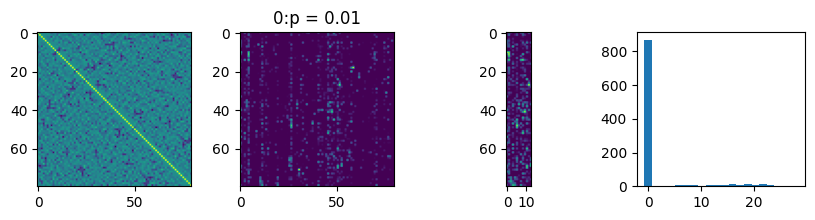

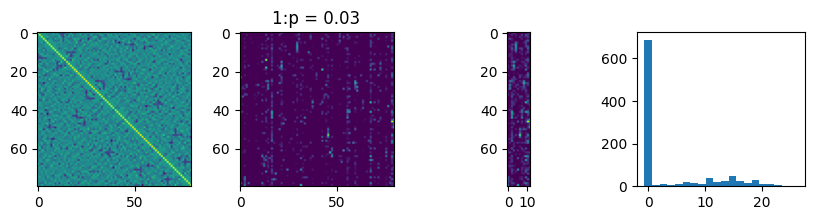

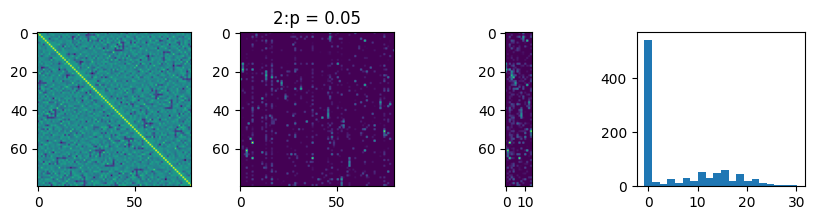

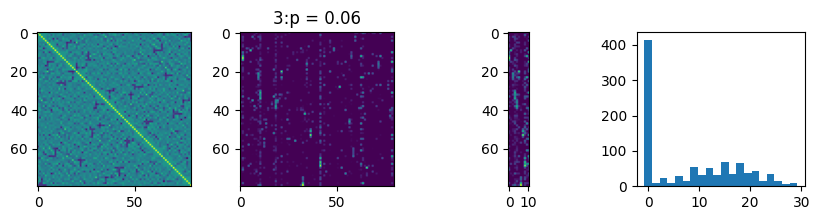

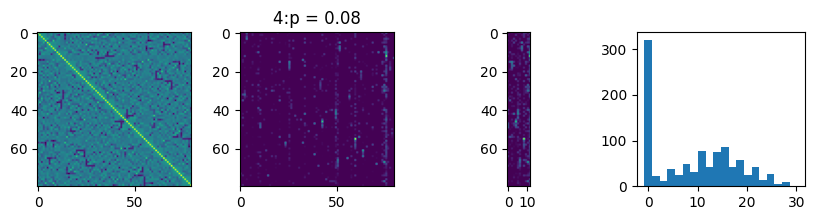

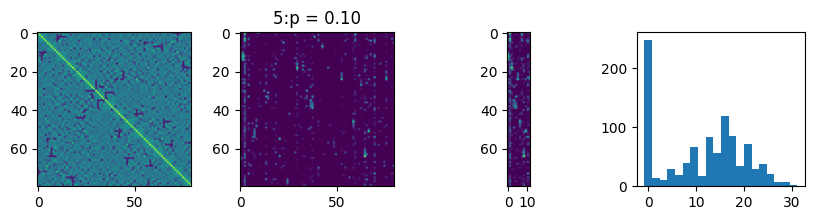

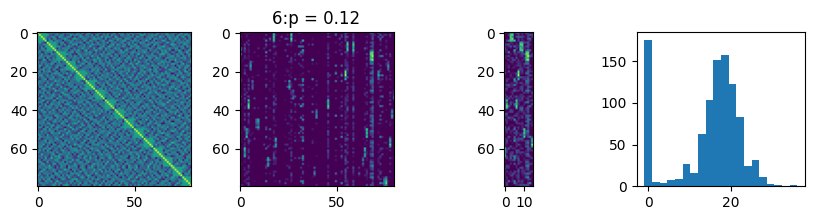

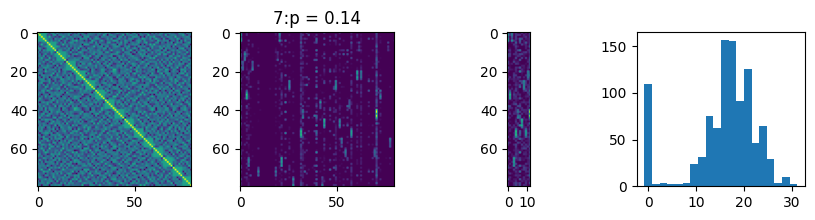

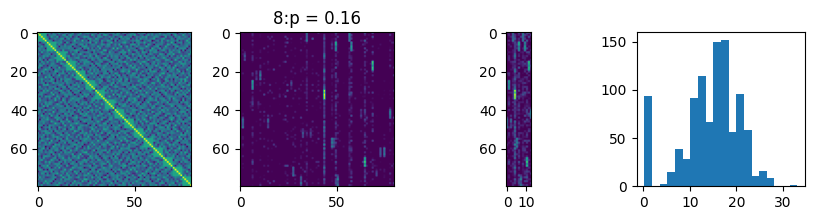

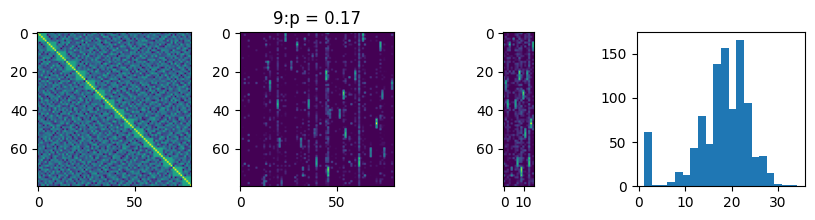

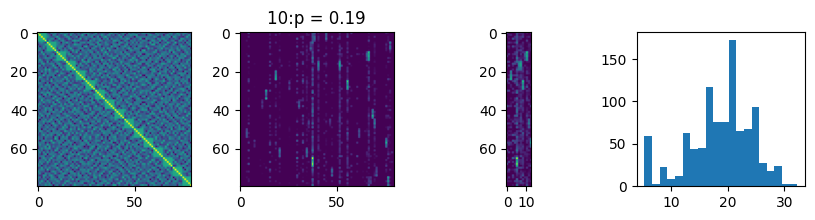

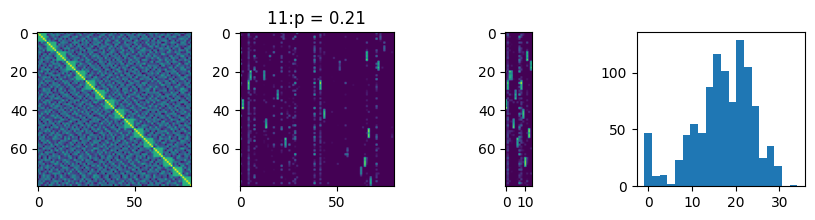

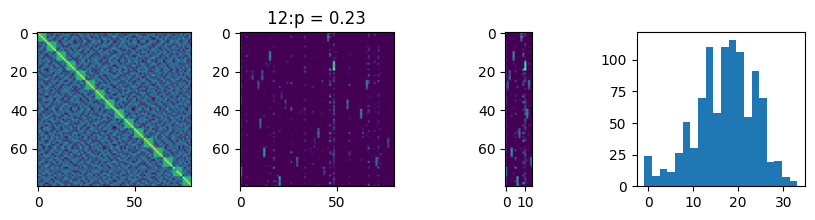

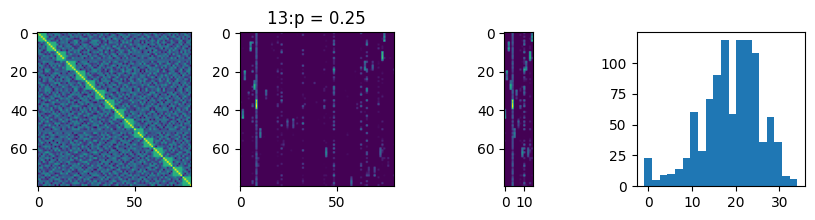

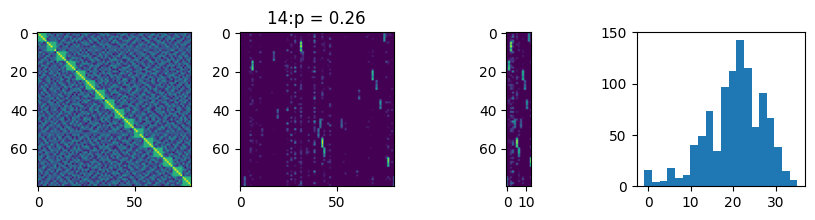

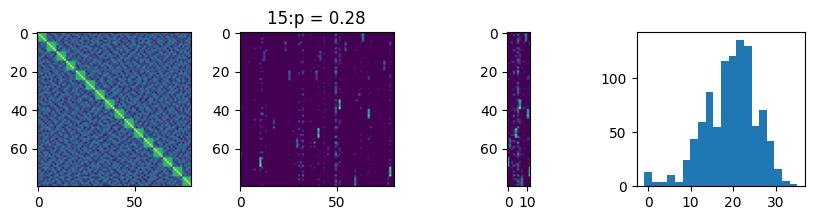

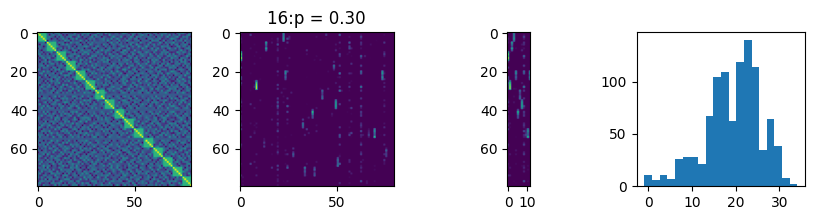

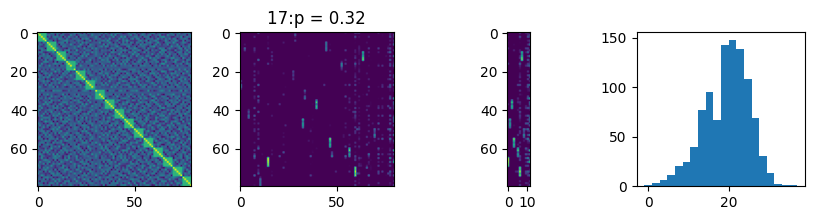

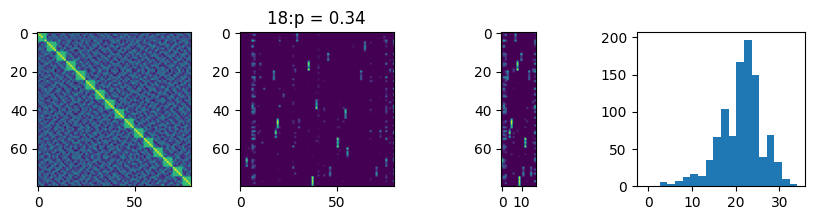

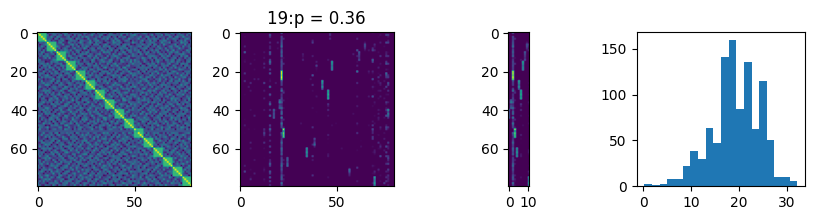

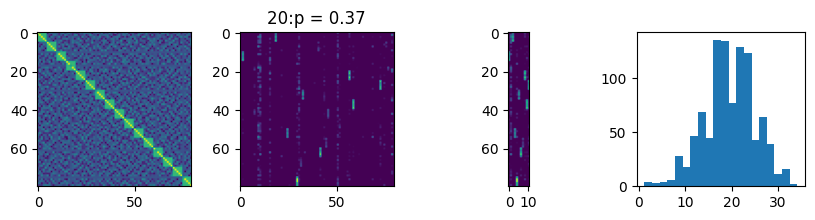

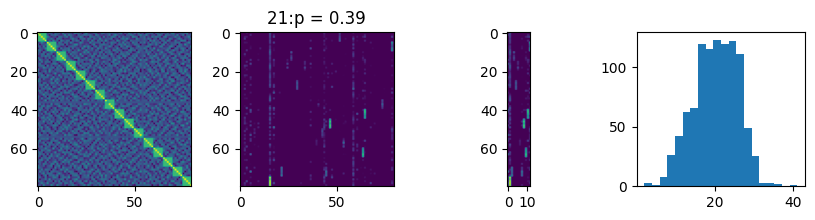

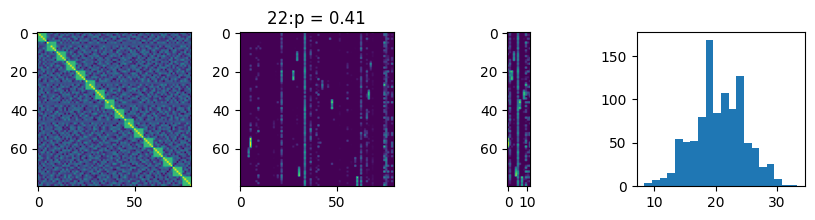

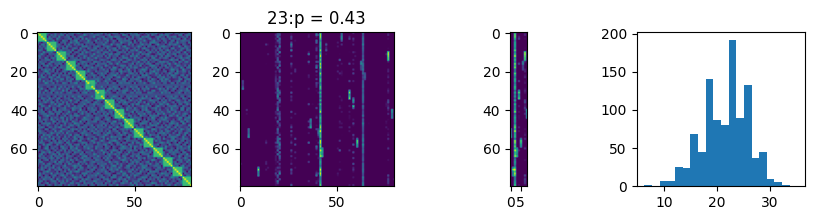

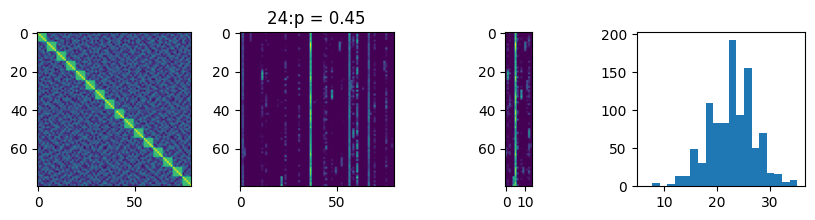

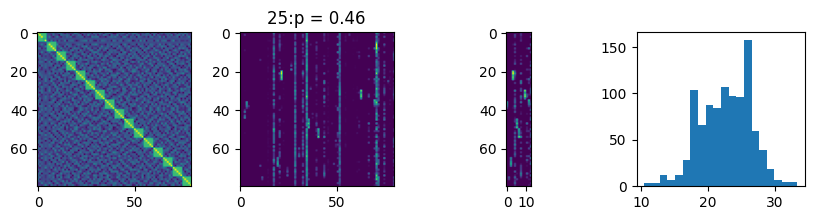

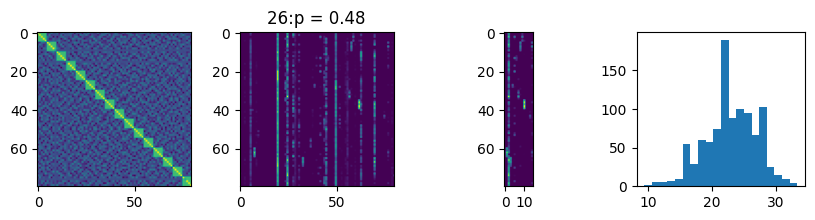

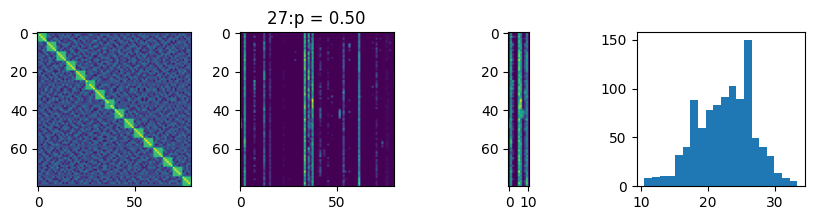

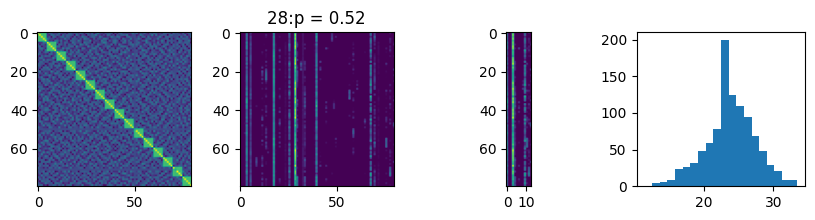

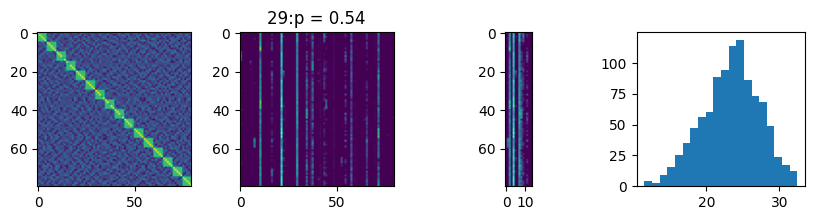

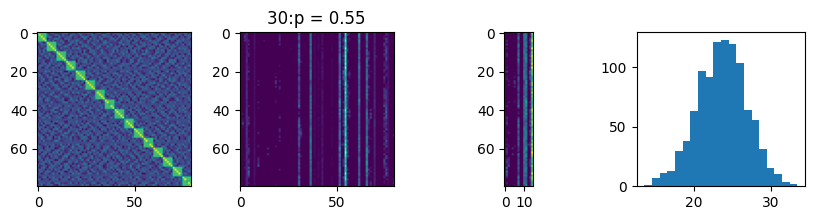

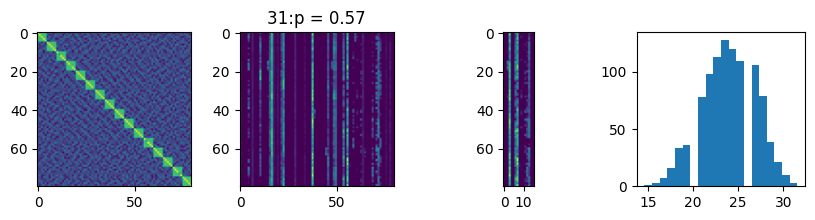

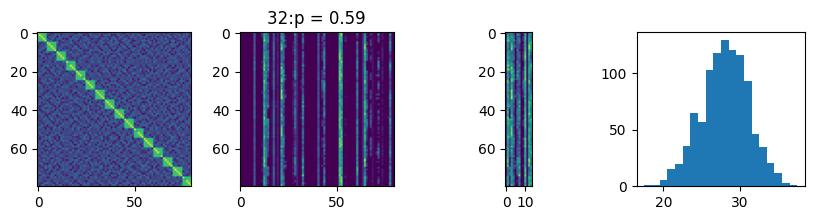

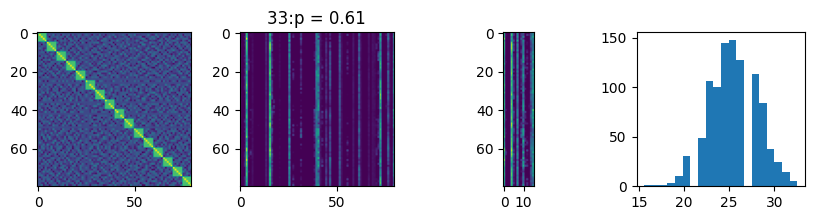

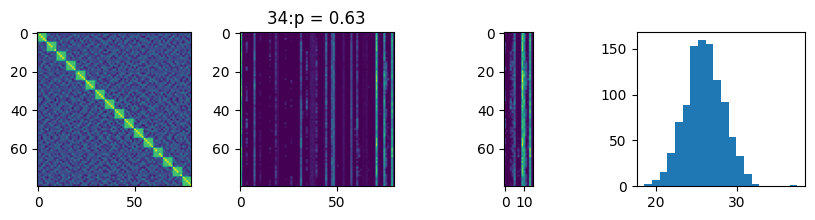

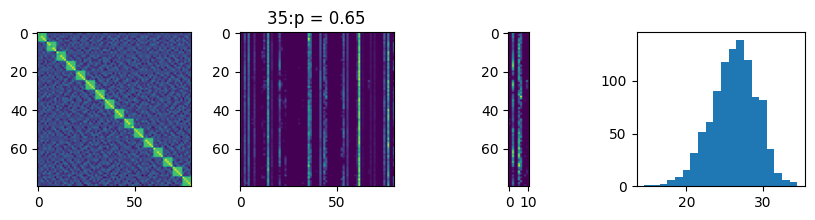

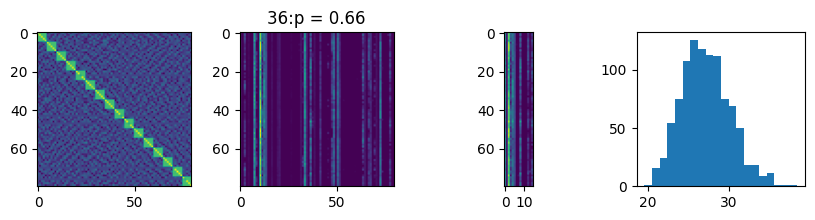

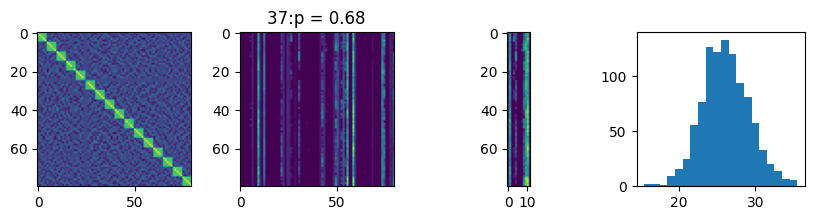

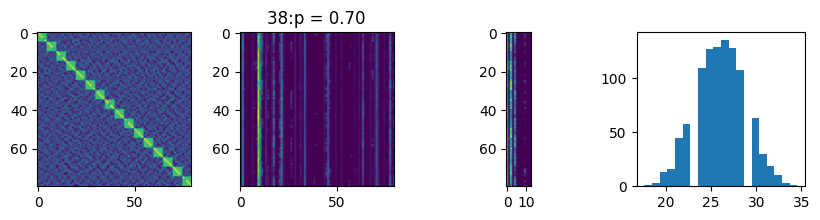

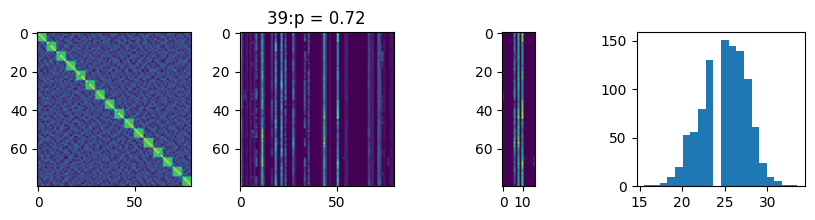

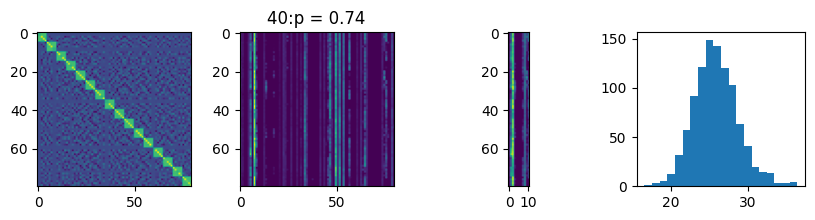

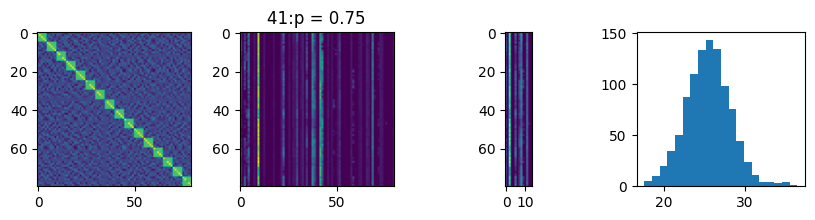

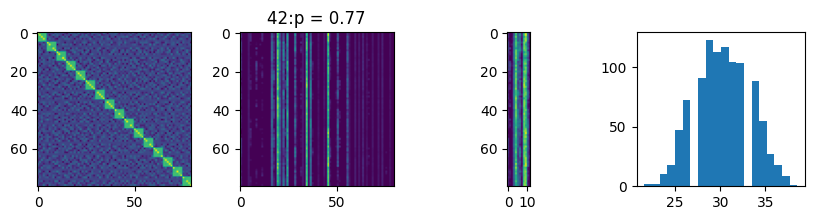

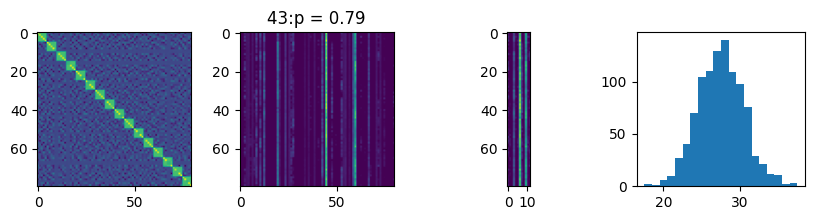

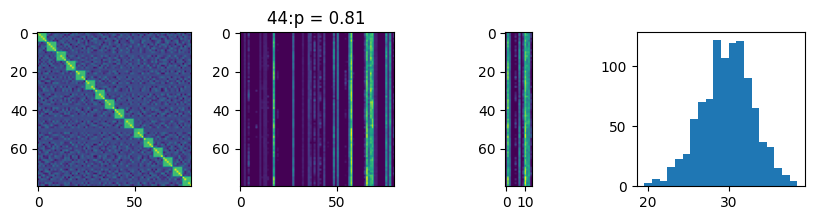

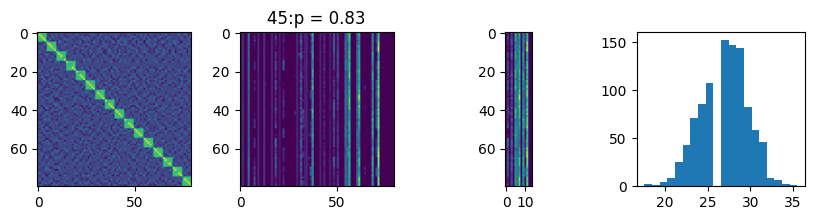

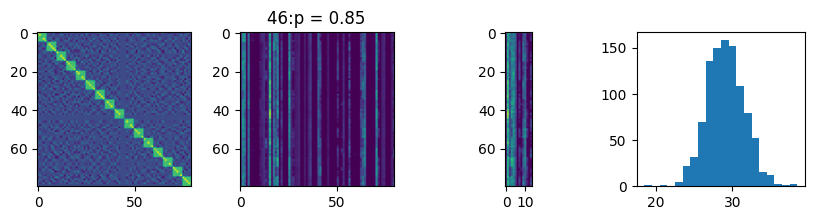

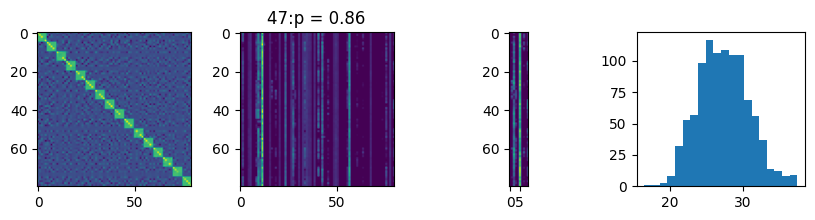

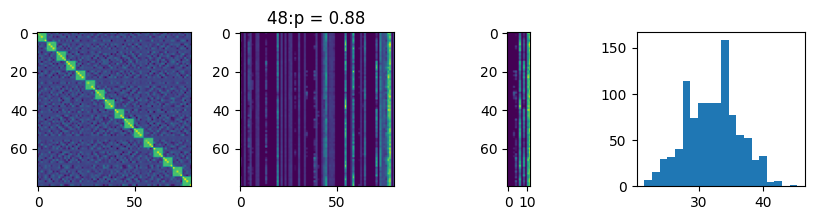

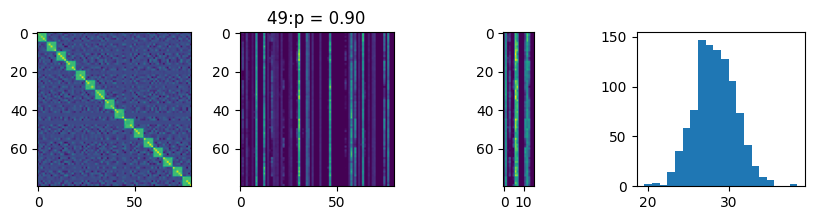

In [13]:

for i, (lf, w, m, p, hist) in enumerate(zip(learned_features, wtw, act_mask, feature_probability, histograms)):
    fig, ax = plt.subplots(1, 4, figsize=(10, 2))
    ax[0].imshow(w)
    ax[1].imshow(lf.T)
    ax[1].set_title(f"{i}:p = {p.item():.2f}")
    ax[2].imshow(lf[m,:].T)
    ax[3].bar(hist[1][:-1], hist[0], width=np.diff(hist[1])[0])
    plt.show()

In [130]:
def real_to_learned_featurs(SAE, model):
    onehots = t.eye(SAE.W_enc.shape[-1])
    onehots = einops.repeat(onehots, "b c ->b (instance) c", instance = SAE.W_enc.shape[0])

    h = model.encode(onehots)

    l1_loss, l2_loss, loss, acts, h_reconstructed = SAE(h)
    return einops.rearrange(acts, "a b c -> b c a").detach().numpy()
learned_features = real_to_learned_featurs(SAE, model)

In [131]:
def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v
        for b in basis:
            w = w - np.dot(v, b) / np.dot(b, b) * b
        if np.linalg.norm(w) > 1e-8:  # Tolerance for numerical stability
            basis.append(w / np.linalg.norm(w))
    return basis

def complete_basis(vectors, check_orthogonal = False):
    n = len(vectors)
    m = vectors[0].shape[0]
    if n >= m:
        raise ValueError("The number of vectors must be less than the dimension of the space.")

    # Ensure the input vectors are orthogonal
    if check_orthogonal:
        vectors = gram_schmidt(vectors)
    else:
        vectors = [v / np.linalg.norm(v) for v in vectors]

    # Generate additional random vectors
    for _ in range(m - n):
        v = np.random.rand(m)
        v = v - np.sum(np.dot(v, b) * b for b in vectors)
        v /= np.linalg.norm(v)
        vectors.append(v)

    return np.array(vectors)
def embedding_span(model,indices):
    input_dim = model.W.shape[2]
    input_vectors = t.zeros((len(indices),1,input_dim))
    for i, v in enumerate(indices):
        input_vectors[i,0,v] = 1.

    hidden = model.encode(input_vectors).detach().numpy()[:,0,:]

    hidden = hidden - np.mean(hidden, axis=0)
    print(hidden.shape)

    #print(hidden.shape)

    pca = PCA(n_components=len(indices))
    pca.fit(hidden)
    #print(pca.components_.shape)

    basis = complete_basis(pca.components_)
    

    variances = pca.explained_variance_
    #exted the variaves by zeros to the input_dim
    variances = np.concatenate([variances, np.zeros(len(basis) - len(variances))])

    #print( pca.explained_variance_)

    #basis = [v for v,e in zip(pca.components_, pca.explained_variance_) if e>0 ]

    return basis, variances
def express_variance_in_different_basis(vacriances, old_basis, new_basis):
    new_variances = []
    for new_vector in new_basis:
        new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))
    return np.array(new_variances)
def create_residual_data(model,sae,n_datapoints = 1000):
    batch = model.generate_batch(n_datapoints)
    h = model.encode(batch)
    l1_loss, l2_loss, loss, acts, h_reconstructed = sae(h)
    residuals = h - h_reconstructed
    return residuals[:,0,:], acts[:,0,:]

def seperate_by_active_feature(residuals,acts,active_features):
    feature_active_mask = acts[:,active_features] > 0
    
    residuals_active = residuals[feature_active_mask]
    residuals_inactive = residuals[~feature_active_mask]

    return residuals_active.detach().numpy(), residuals_inactive.detach().numpy()

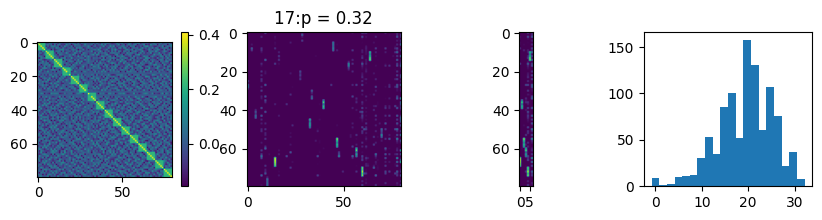

In [143]:
i_choice = 17


for i, (lf, w, m, p, hist) in enumerate(zip(learned_features, wtw, act_mask, feature_probability, histograms)):
    if i != i_choice:
        continue
    fig, ax = plt.subplots(1, 4, figsize=(10, 2))
    im0 = ax[0].imshow(w)
    fig.colorbar(im0, ax=ax[0])
    ax[1].imshow(lf.T)
    ax[1].set_title(f"{i}:p = {p.item():.2f}")
    ax[2].imshow(lf[m,:].T)
    ax[3].bar(hist[1][:-1], hist[0], width=np.diff(hist[1])[0])
    plt.show()

model_choice =  model.select(i_choice)
#model_choice.feature_probability = 
sae_choice = SAE.select(i_choice)

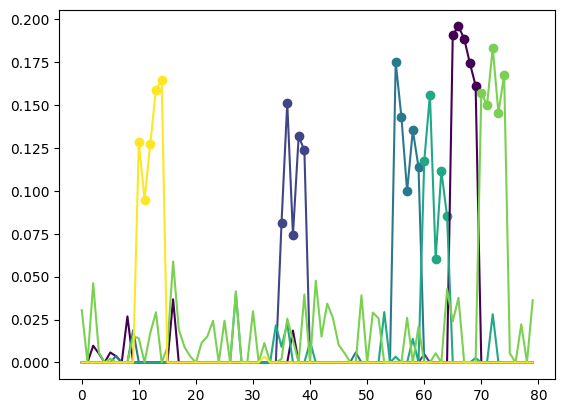

In [144]:
act_mask[i_choice]
indices = [i for i in range(len(act_mask[i_choice])) if act_mask[i_choice][i] and max(learned_features[i_choice][i]) > 0.1] 
colors = plt.cm.viridis(np.linspace(0,1,len(indices)))

for i, c in zip(indices, colors):
    lf = learned_features[i_choice][i]
    real_features = [j for j in range(len(lf)) if lf[j] > 0.06]
    plt.plot(lf, color=c)
    plt.scatter(real_features, lf[real_features], color=c)
plt.show()

(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)
C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


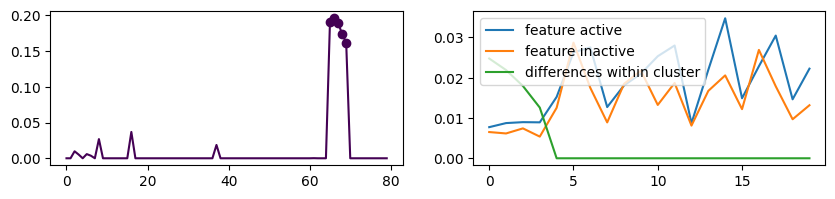

C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


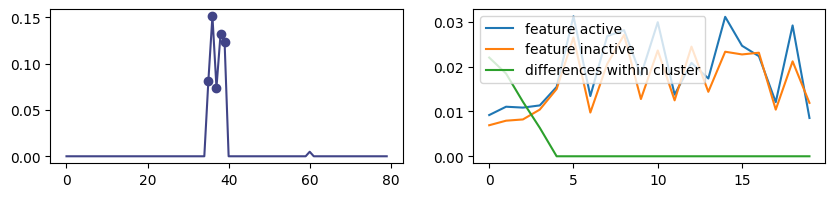

C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


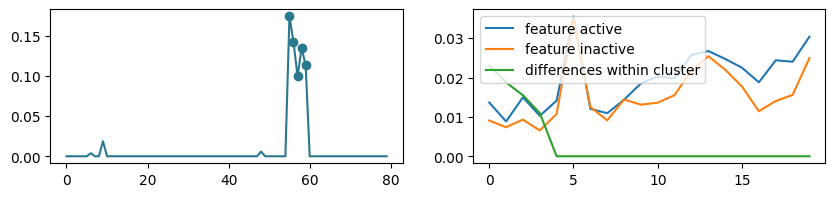

C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


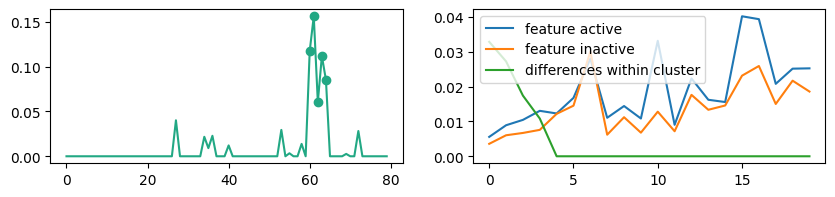

C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


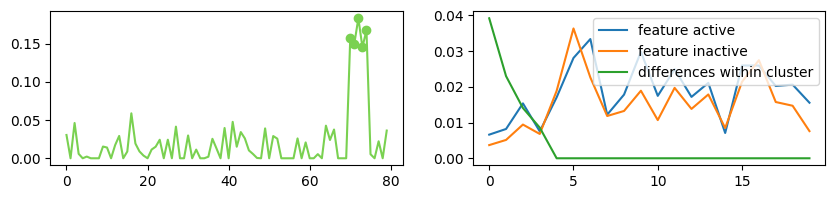

C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


(5, 20)


C:\Users\wusch\AppData\Local\Temp\ipykernel_27468\907045824.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_variances.append(np.sum((np.dot(new_vector, old_vector))**2 * variance for old_vector, variance in zip(old_basis, vacriances)))


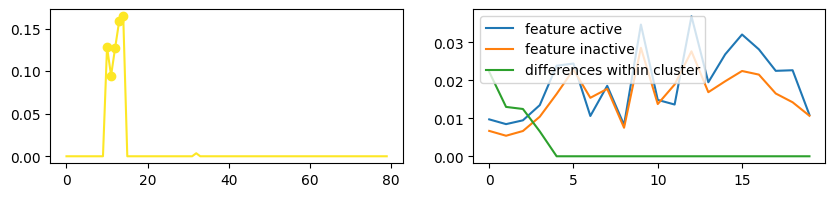

In [145]:
act_mask[i_choice]
indices = [i for i in range(len(act_mask[i_choice])) if act_mask[i_choice][i] and max(learned_features[i_choice][i]) > 0.1] 
colors = plt.cm.viridis(np.linspace(0,1,len(indices)))

for i, c in zip(indices, colors):
    lf = learned_features[i_choice][i]
    real_features = [j for j in range(len(lf)) if lf[j] > 0.06]
    fig, ax = plt.subplots(1, 2, figsize=(10, 2))
    ax[0].plot(lf, color=c)
    ax[0].scatter(real_features, lf[real_features], color=c)

    basis, variances =embedding_span(model_choice,real_features)
    residuals, acts = create_residual_data(model_choice,sae_choice, n_datapoints = 100000)
    residuals_active, residuals_inactive = seperate_by_active_feature(residuals,acts,i)
    pca_avtive = PCA(n_components=n_hidden)
    
    pca_inactive = PCA(n_components=n_hidden)
    pca_avtive.fit_transform(residuals_active)
    pca_inactive.fit_transform(residuals_inactive)

    active_variances = express_variance_in_different_basis(pca_avtive.explained_variance_, pca_avtive.components_, basis)
    inactive_variances = express_variance_in_different_basis(pca_inactive.explained_variance_, pca_inactive.components_, basis)

    ax[1].plot(active_variances, label = "feature active")
    ax[1].plot(inactive_variances, label = "feature inactive")
    ax[1].plot(variances, label = "differences within cluster")
    ax[1].legend()
    plt.show()